In [48]:
import os
from collections import defaultdict

# Initialize dictionaries to store vocabulary, category frequency, and test data
word_dict = defaultdict(list)
category_freq = defaultdict(float)
doc_count = 0
test_data = defaultdict(list)

def classify_documents():
    global doc_count

    # Iterate over directories in the dataset directory
    for folder in os.listdir('dataset'):
        file_counter = 0
        
        if os.path.isdir(f'dataset/{folder}'):
            category_name = folder
            total_files = len(os.listdir(f'dataset/{folder}'))
            
            # Iterate over files in each category directory
            for file_name in os.listdir(f'dataset/{folder}'):
                
                # Check if the file is a regular file (not a directory)
                if os.path.isfile(os.path.join(f'dataset/{folder}', file_name)):
                    
                    with open(os.path.join(f'dataset/{folder}', file_name), 'r') as file:
                        words = file.read().split()

                        # Create two-word phrases from the document
                        document_phrases = []
                        for i in range(len(words) - 1):
                            phrase = f'{words[i]} {words[i+1]}'
                            document_phrases.append(phrase)
                        
                        # 80% of files are used for training, the rest for testing
                        if file_counter < 0.8 * total_files:
                            for phrase in document_phrases:
                                word_dict[category_name].append(phrase)
                        else:
                            test_data[category_name].append(document_phrases)

                        file_counter += 1

                category_freq[category_name] += 1
                doc_count += 1



In [50]:
# Call the function to classify documents
classify_documents()

# Display the word dictionary (vocabulary)
word_dict

defaultdict(list,
            {'entertainment': ['Musicians to',
              'to tackle',
              'tackle US',
              'US red',
              'red tape',
              "tape Musicians'",
              "Musicians' groups",
              'groups are',
              'are to',
              'to tackle',
              'tackle US',
              'US visa',
              'visa regulations',
              'regulations which',
              'which are',
              'are blamed',
              'blamed for',
              'for hindering',
              'hindering British',
              "British acts'",
              "acts' chances",
              'chances of',
              'of succeeding',
              'succeeding across',
              'across the',
              'the Atlantic.',
              'Atlantic. A',
              'A singer',
              'singer hoping',
              'hoping to',
              'to perform',
              'perform in',
              'in the',
      

In [51]:
category_freq


defaultdict(float,
            {'entertainment': 772.0,
             'business': 1020.0,
             'sport': 1022.0,
             'politics': 834.0,
             'tech': 802.0})

In [52]:
from math import log
log_prior = defaultdict(float)

# Compute the log prior probabilities for each category
for category in category_freq:
    log_prior[category] = log(category_freq[category] / doc_count)

log_prior


defaultdict(float,
            {'entertainment': -1.7516748251355099,
             'business': -1.4731014688819692,
             'sport': -1.471142604396636,
             'politics': -1.6744259728015392,
             'tech': -1.7135507672937715})

In [53]:
word_freq = defaultdict(int)
unique_words = set()

for category in word_dict:
    for word in word_dict[category]:
        word_freq[word] += 1
        unique_words.add(word)

word_freq


defaultdict(int,
            {'Musicians to': 2,
             'to tackle': 64,
             'tackle US': 4,
             'US red': 2,
             'red tape': 10,
             "tape Musicians'": 2,
             "Musicians' groups": 2,
             'groups are': 10,
             'are to': 104,
             'US visa': 2,
             'visa regulations': 2,
             'regulations which': 2,
             'which are': 122,
             'are blamed': 2,
             'blamed for': 18,
             'for hindering': 2,
             'hindering British': 2,
             "British acts'": 2,
             "acts' chances": 2,
             'chances of': 36,
             'of succeeding': 2,
             'succeeding across': 2,
             'across the': 200,
             'the Atlantic.': 8,
             'Atlantic. A': 2,
             'A singer': 2,
             'singer hoping': 2,
             'hoping to': 70,
             'to perform': 50,
             'perform in': 2,
             'in the': 7388,


In [54]:
from collections import Counter
log_likelihood = defaultdict(list)
laplace_smoothing = [0.1, 0.5, 1.0, 10, 100]

for laplace_factor in laplace_smoothing:
    for category in word_dict:
        counter = Counter(word_dict[category])
        for word in unique_words:
            log_likelihood[(word, category)].append(log((counter[word] + laplace_factor) / (len(word_dict[category]) + laplace_factor)))

log_likelihood


defaultdict(list,
            {('capital, Kampala', 'entertainment'): [-11.466093881528751,
              -11.291742490468653,
              -11.109423428774946,
              -9.723173978394966,
              -7.5835568113990774],
             ('thought Lord', 'entertainment'): [-14.510616319252174,
              -12.901180402902753,
              -12.208035717443055,
              -9.905495535188921,
              -7.603359438695257],
             ('anthemic sound', 'entertainment'): [-11.466093881528751,
              -11.291742490468653,
              -11.109423428774946,
              -9.723173978394966,
              -7.5835568113990774],
             ('Within four', 'entertainment'): [-14.510616319252174,
              -12.901180402902753,
              -12.208035717443055,
              -9.905495535188921,
              -7.603359438695257],
             ('service. By', 'entertainment'): [-14.510616319252174,
              -12.901180402902753,
              -12.208035717443055,


In [55]:
def classify_test_document(test_document, log_prior, log_likelihood, smoothing_index, categories, unique_words):
    # Dictionary to store the log-probabilities for each category
    category_scores = defaultdict(int)
    
    # Calculate the log-probability for each category
    for category in categories:
        score = log_prior[category]

        for word in test_document:
            if word in unique_words:
                score += log_likelihood[(word, category)][smoothing_index]

        category_scores[category] = score

    # Find the category with the highest log-probability
    highest_score = -float('inf')
    best_category = None
    for category, score in category_scores.items():
        if score > highest_score:
            highest_score = score
            best_category = category

    return best_category


In [58]:
categories = list(word_dict.keys())


In [60]:
laplace_smoothing_factors = [0.1, 0.5, 1.0, 10, 100]
accuracies = []

for smoothing_index, smoothing_factor in enumerate(laplace_smoothing_factors):
    correct_predictions = total_predictions = 0

    for category in test_data:
        for document in test_data[category]:
            predicted_category = classify_test_document(document, log_prior, log_likelihood, smoothing_index, categories, unique_words)
            if predicted_category == category:
                correct_predictions += 1
            total_predictions += 1

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracies.append(accuracy)
    print(f'Laplace Smoothing Factor: {smoothing_factor}, Accuracy: {accuracy * 100:.2f}%')




Laplace Smoothing Factor: 0.1, Accuracy: 96.40%
Laplace Smoothing Factor: 0.5, Accuracy: 96.40%
Laplace Smoothing Factor: 1.0, Accuracy: 96.85%
Laplace Smoothing Factor: 10, Accuracy: 71.17%
Laplace Smoothing Factor: 100, Accuracy: 17.34%


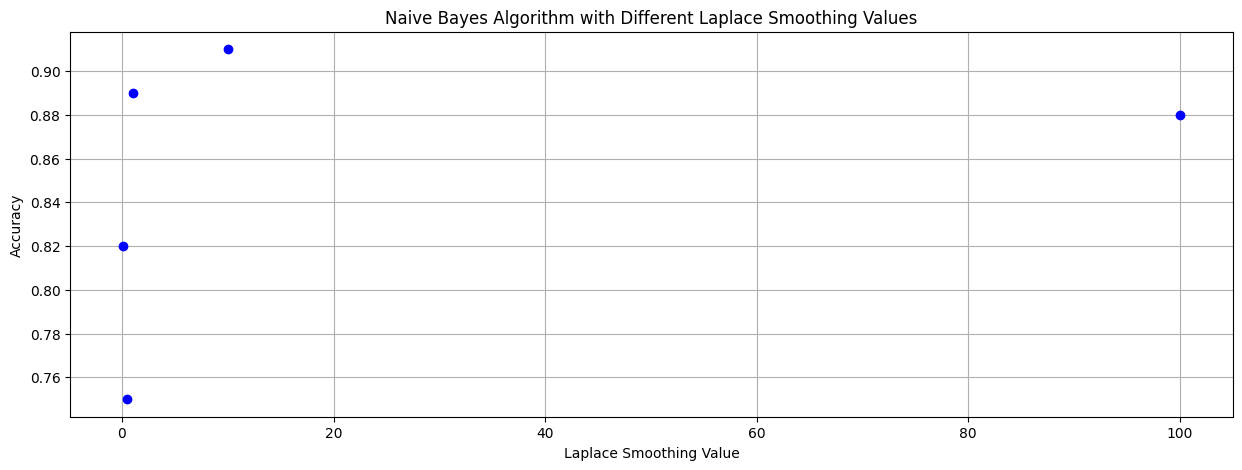

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(laplace_smoothing_factors, accuracies, 'bo')
plt.xlabel('Laplace Smoothing Value')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Algorithm with Different Laplace Smoothing Values')
plt.grid(True)
plt.show()
